# MCMC para datos de patrón de sueño

### Usaremos los datos tomados por un smart watch, el cual registra el tiempo en el que una persona se queda dormida y despiesta cada día. Teniendo como objetivo conocer la periodicidad de este proceso y se propone una posible forma de modelarlo, lo cual podemos ver al final que obtenemos un buen fit para ello.

In [1]:
import pandas as pd
import numpy as np
from scipy import optimize as op
import matplotlib.pyplot as plt
import corner
%matplotlib inline

In [2]:
#Lee los datos
sleep_data = pd.read_csv('data_sleeping/sleep_data_1.csv')
wake_data = pd.read_csv('data_sleeping/wake_data_1.csv')
# Labels
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

In [3]:
print('Numero de observaciones %d' % len(sleep_data))

Numero de observaciones 11340


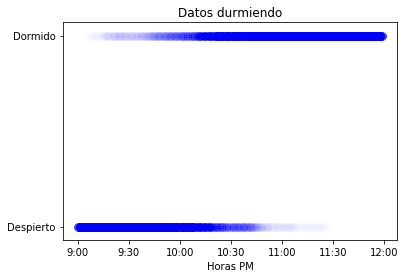

In [4]:
# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Despierto', 'Dormido'])
plt.xlabel('Horas PM') 
plt.title('Datos durmiendo')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels)
plt.show()

# Por la forma de los datos proponemos que la función que mejor se ajuste sea de la forma  $\frac{1}{1 + e^{-\beta t - \alpha}}$ (sigmoid) donde obtendremos los parámetros $\alpha$ y $\beta$ 

In [5]:
#Definición del modelo
def mod(time,a,b):
    return 1. / (1. + np.exp(np.dot(a, time) + b))

Para poder obtener los errores de los datos obtenidos reacomodamos los indicadores, los cuales nos dicen si la persona está dormida o no, tomando en cuenta que la aplicación registra minuto a minuto si la persona está dormida o no en un lapso fijo de tres horas (180 minutos)y los datos que se tienen son por 63 días.

Las barras de error fueron obtenidas al promediar cada uno de los días, tomando en cuenta si la persona estaba dormida o no en cada minuto.

In [6]:
#Reorganiza los datos
new_data = np.array(sleep_data['indicator']).reshape((63,180))

In [7]:
r = np.mean(new_data, axis=0)#datos, toma el valor promedio de cada uno de los días para así saber si la persona estaba dormida o no
sigmas2 = np. std(new_data, axis=0)#Calcula la desviación estándar de los datos
sigmas = np.sqrt(sigmas2)#sigmas

In [8]:
#Se cabió el tiempo de -1 a 1
timer = np.linspace(-1.,1.,180)

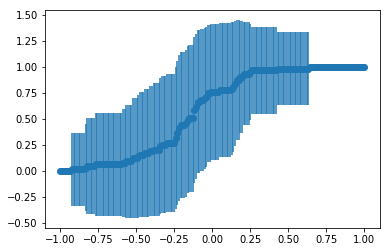

In [9]:
plt.errorbar(timer,r,yerr=sigmas,fmt="o");

De la gráfica anterior podemos notar que no tenemos errores en ciertos datos por lo que al hacer la división en el likelihood obtendremos un error, así que los quitamos con lo siguiente

In [10]:
mask = sigmas!=0.0

In [11]:
sigmas = sigmas[mask]

In [12]:
timer = timer[mask]
r = r[mask]

In [13]:
#Usamos el ln de un likehood Gaussiano
def lnlike(theta, time, y, yerr):
    alpha, beta = theta
    model = 1. / (1. + np.exp(-1.0*(alpha*time + beta)))
    return -0.5*(np.sum(((y-model)/yerr)**2 + np.log(2.*np.pi*yerr**2)))

Para iniciar las cadenas en valores para $\alpha$ y $\beta$ con mayor probabilodad tomamos el máximo de likelihood, el cual tomaremos más adelante como paso inicial para la cadena

In [14]:
fun = lambda *args: -lnlike(*args)

In [15]:
result = op.minimize(fun,[0.,0.],args=(timer,r,sigmas),method='L-BFGS-B')

In [16]:
#Valores que tomaremos para el prior
plist= [0.0,20.0,0.0,3.0]

In [17]:
#Prior
def lnprior(theta, plist):
    a, b = theta
    if plist[0] < a< plist[1] and plist[2] < b < plist[3]:
        return 0.0
    return -np.inf

In [18]:
#Postior
def posti(theta,time, y, yerr):
    lp = lnprior(theta, plist)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, time, y, yerr)

In [19]:
# Numero de samples para el MCMC
N_SAMPLES = 10000
cadena = []#Guardara datos de cadena
pcadena = []
paso_i = [0.,0.]#paso inicial

In [20]:
#Función que hace el algoritmo de metropolis con un caminador y N_SAMPLEs
def mc(pasos, paso_inicial):
    
    cadena = []
    pcadena = []
    theta_old = paso_inicial
    for i in range(N_SAMPLES):
        a_new = theta_old[0] + 1e-3*np.random.normal()
        b_new = theta_old[1] + 1e-3*np.random.normal()
        
        theta_new = [a_new, b_new]
        p_new = posti(theta_new,timer, r, sigmas)
        p_old = posti(theta_old,timer, r, sigmas)
        if (p_new/p_old>1):
            theta_old = theta_new
            cadena.append(theta_old)
            pcadena.append(p_new)
            paso_inicial = theta_old
        else:
            f = np.random.uniform(0.,1.)
            if (p_new/p_old>= f):
                theta_old = theta_new
                cadena.append(theta_old)
                pcadena.append(p_new)
                paso_i = theta_old
            else:
                continue
    cadena = np.array(cadena)
    pcadena = np.array(pcadena)
    return cadena, pcadena

In [21]:
cad = []
pcad = []

In [22]:
cad,pcad = mc(N_SAMPLES, result.x)

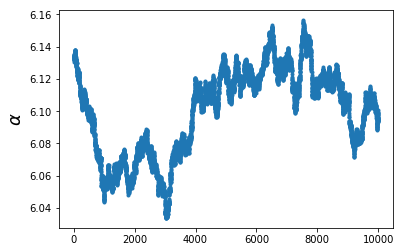

In [23]:
plt.plot(cad[:,0],'.')
plt.ylabel(r'$\alpha$',fontsize=18)
plt.show()

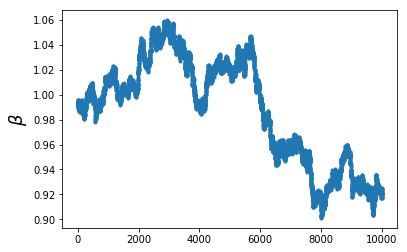

In [24]:
plt.plot(cad[:,1],'.')
plt.ylabel(r'$\beta$',fontsize=18)
plt.show()

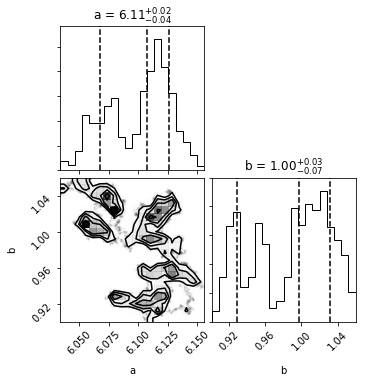

In [25]:
#aquí a = alpha y b = beta
corner.corner(cad, labels=['a','b'],quantiles=[0.16,0.5,0.84],show_titles=True);

In [26]:
models = 1. / (1. + np.exp( -1.0*(6.16*timer + 1.07)))

In [55]:
#punto de inflexion
np.diff(models).max()

0.017200813090332445

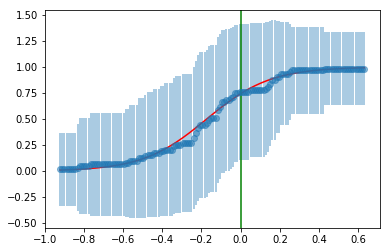

In [61]:
plt.plot(timer,models,'r');
plt.axvline(np.diff(models).min(),color='g')
plt.errorbar(timer,r,yerr=sigmas,fmt="o",alpha=0.5);

Lamentablemente, como podemos ver en las gráficas del caminante para $\alpha$ y $\beta$, no convergen, haciendo falta más tiempo de cómputo.
Por otro lado, podemos ver que los valores obtenidos para $\alpha$ y $\beta$ se ajustan bien respecto a la gráfica anterior(línea roja). 
La gráfica anterior nos muestra el lapso en el que una persona pasa de estar dormida a despierta, por lo que el punto de inflexión de ésta nos indicaría la hora en la que la persona comienza a estar dormida, en este caso obtenemos que nuestro punto de inflexión de 0.017 corresponde a las 10:35PM, realizando una regla de tres sabiendo que el 1. en nistros datos corresponde a las 11:59PM.